In [6]:
##### for running it on google colab, these commands are needed to be run first to install Lunar Lander environment
!pip install gym
!pip install "gym[box2d]"

     |████████████████████████████████| 450kB 2.8MB/s 


In [0]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import gym
import random
import copy

In [ ]:
##### deifning the ornstein uhlenbeck noise #####

In [0]:
class OU:
    def __init__(self, size, seed, mu=0., theta=0.15, sigma=0.2):
        """Initialize parameters and noise process."""
        self.mu = mu * np.ones(size)
        self.theta = theta
        self.sigma = sigma
        self.seed = random.seed(seed)
        self.size = size
        self.reset()

    def reset(self):
        """Reset the internal state (= noise) to mean (mu)."""
        self.state = copy.copy(self.mu)

    def sample(self):
        """Update internal state and return it as a noise sample."""
        x = self.state
        dx = self.theta * (self.mu - x) + self.sigma * np.random.standard_normal(self.size)
        self.state = x + dx
        return self.state

In [0]:
noise = OU((1,2),0)

In [10]:
noise.sample()[0]

array([-0.07381944, -0.01366573])

In [11]:
# env = gym.make('MountainCarContinuous-v0')
env = gym.make('LunarLanderContinuous-v2')

/usr/local/lib/python3.6/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


In [0]:
state = env.reset()

In [0]:
device = 'cuda:0'

In [14]:
torch.autograd.set_detect_anomaly(True)

In [0]:
##### function used to copy parameters of a model to another ####

In [0]:
def copy_params(model1, model2):
  for a,b in zip(model1.parameters(),model2.parameters()):
    b.data = copy.deepcopy(a.data)

In [ ]:
#### function used to soft update the target networks ####

In [0]:
def soft_update(local_model, target_model, tau):
  for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
    target_param.data = copy.deepcopy(tau*local_param.data + (1.0-tau)*target_param.data)

In [ ]:
###### function to update the parameters of the networks ####

In [0]:
def update_params(D):
  pol1.zero_grad()
  Q1.zero_grad()
  pol2.zero_grad()
  Q2.zero_grad()
  ind = np.random.choice(range(len(D)), min(64,len(D)), replace=False)
  t = 0
  d = []
  for i in ind:
    s1 = torch.Tensor(D[i][0]).to(device)
    a1 = D[i][1].detach()
    r = D[i][2]
    s2 = torch.Tensor(D[i][3]).to(device)
    d.append(D[i][4])
    if(t==0):
      state2 = s2.unsqueeze(dim=0)
      state1 = s1.unsqueeze(dim=0)
      act1 = a1.unsqueeze(dim=0)
      rew = torch.Tensor([r])
      t=1
    else:
      state2 = torch.cat([state2,s2.unsqueeze(dim=0)],dim = 0)
      state1 = torch.cat([state1,s1.unsqueeze(dim=0)],dim = 0)
      act1 = torch.cat([act1,a1.unsqueeze(dim=0)],dim = 0)
      rew = torch.cat([rew,torch.Tensor([r])])
  


  state2 = state2.to(device)
  act1 = act1.to(device)
  rew = rew.to(device)
  done = torch.Tensor(d).to(device)

  act2 = pol2(state2)
  # print("s1",state1.shape)
  # print("act1",act1.shape)
  # print("rew",rew.shape)
  # print("s2",state2.shape)
  # print("act2",act2.shape)
  # print("done",done.shape)
  y = rew.reshape([rew.shape[0],1]) + 0.99*Q2(state2,act2)*(1-done.reshape([done.shape[0],1]))
  q = Q1(state1,act1)
  loss1 = F.mse_loss(q,y)
  # print("loss1",loss1)
  opt1.zero_grad()
  loss1.backward()
  opt1.step()
  
  act3 = pol1(state1)
  loss2 = -1*Q1(state1,act3).mean()
  # print("loss2",loss2)
  opt2.zero_grad()
  loss2.backward()
  opt2.step()

  soft_update(Q1, Q2, TAU)
  soft_update(pol1, pol2, TAU) 

  return loss1

In [0]:
class Q_net(nn.Module):
  def __init__(self, state_size, action_size):
    super(Q_net, self).__init__()
    self.fcs1 = nn.Linear(state_size, 40)
    self.fc2 = nn.Linear(40+action_size, 30)
    self.fc3 = nn.Linear(30, 1)

  def forward(self, state, action):
    xs = F.relu(self.fcs1(state))
    x = torch.cat((xs, action), dim=1)
    x = F.relu(self.fc2(x))
    return self.fc3(x)

In [33]:
TAU = 1e-3

pol1 = nn.Sequential(nn.Linear(8,20),nn.ReLU(),nn.Linear(20,15),nn.ReLU(),nn.Linear(15,2),nn.Tanh()).to(device)
pol2 = nn.Sequential(nn.Linear(8,20),nn.ReLU(),nn.Linear(20,15),nn.ReLU(),nn.Linear(15,2),nn.Tanh()).to(device)
copy_params(pol1,pol2)
## pol1 is the local actor and pol2 is the target actor

Q1 = Q_net(8,2).to(device)
Q2 = Q_net(8,2).to(device)
copy_params(Q1,Q2)
## Q1 is the local critic and Q2 is the target critic

opt1 = torch.optim.Adam(Q1.parameters(),lr = 0.01)
opt2 = torch.optim.Adam(pol1.parameters(),lr = 0.001)
R = []
D = []
for episode in range(0,400):
  state = env.reset()
  done = False
  r = 0
  noise.reset()
  while(done!=True):
    if(len(D)>=50000):
      D = []
    for k in range(0,64):
      pol1.zero_grad()
      Q1.zero_grad()
      action = pol1(torch.Tensor(state).to(device)) 
      N = noise.sample()[0]
      # print(np.clip(action.item()+N,-1,1))
      a = [np.clip(action[0].item()+N[0],-1,1),np.clip(action[1].item()+N[1],-1,1)]
      # a = [np.clip(action.item()+N,-1,1)]
      # print(a)
      state1,reward,done,_ = env.step(a)
      # state1 = [a.item() for b in state1 for a in b]
      D.append([state,action,reward,state1,done])
      if(len(D)>=64):
        loss = update_params(D)
      # if(reward>50):
      #   print("yes")
      state = copy.deepcopy(state1)
      r+=reward
      if(done==True):
        break;
    # if(len(D)!=1):
    #   loss = update_params(D)
  # print(Q1.fc3.weight.grad)
  R.append(r)
  print("Episode ",episode,"Reward",r,"R",sum(R)/len(R))  # R printed during training is the mean of the episodic rewards collected so far

Episode  0 Reward -13.528567609811574 R -13.528567609811574
Episode  1 Reward -230.15894009575942 R -121.8437538527855
Episode  2 Reward -292.89639826964697 R -178.8613019917393
Episode  3 Reward -405.2832545133495 R -235.46679012214184
Episode  4 Reward -456.33863804661456 R -279.64115970703637
Episode  5 Reward -913.7942707624983 R -385.3333448829467
Episode  6 Reward -733.4643952309258 R -435.0663520755151
Episode  7 Reward -588.4947977934474 R -454.24490779025666
Episode  8 Reward -332.11898119105956 R -440.6753603903459
Episode  9 Reward -551.0847658538502 R -451.71630093669626
Episode  10 Reward -1041.015111219152 R -505.2889200532832
Episode  11 Reward -1023.0472013128923 R -548.4354434915839
Episode  12 Reward -933.4795752934454 R -578.0542228609579
Episode  13 Reward -544.9085648072485 R -575.6866758571215
Episode  14 Reward -503.1127806487336 R -570.8484161765623
Episode  15 Reward -596.9923253180559 R -572.4824104979057
Episode  16 Reward -531.1895264899216 R -570.0534173209

In [ ]:
### function to calculate moving average ###

In [0]:
def moving_average(a, n=3) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

In [0]:
RR = moving_average(R,5)

In [ ]:
### plotting episodic reward ####

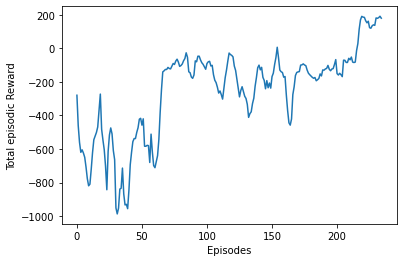

In [52]:
plt.plot(RR[:235])
plt.xlabel("Episodes")
plt.ylabel("Total episodic Reward")
plt.show()